# Train a neural network.

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Set seeds

In [2]:
np.random.seed(1)
tf.random.set_seed(1)

Set parameters

In [3]:
# file with training input and output data: format is x,y
input_file = 'ramp_training_data_with_0_velocity.csv'

# names of input/output columns
inputs = ['angle', 'length', 'velocity']
outputs = ['success']

# these set the input/output dimensions of the network
input_size = len(inputs)
output_size = len(outputs)

Read data

In [4]:
data = pd.read_csv(input_file)
data.columns = inputs + outputs

x = np.array(data[inputs])
y = np.array(data[outputs])

Normalizing preprocessing layer from training data

In [5]:
normalizer = keras.layers.experimental.preprocessing.Normalization()
normalizer.adapt(x)

Penalize overpredictions more than underpredictions

In [6]:
# def asymmetric_mse(y_true, y_pred):
#     standard_mse = keras.losses.mse(y_true, y_pred)
#     geq = keras.backend.any(keras.backend.greater(y_pred, y_true)) # true/false, are there overpredictions?
#     geq_scale = keras.backend.switch(geq,5.0,1.0) # if there are overpredictions, scale up mse
#     return geq_scale * standard_mse

Base model

In [7]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(input_size, activation='linear'))
model.add(keras.layers.Dense(10,activation='relu'))
#model.add(keras.layers.Dense(10,activation='relu'))
model.add(keras.layers.Dense(output_size,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam')

Compile model

In [8]:
input_shape = x.shape[1:]
full_model_input = keras.Input(shape=input_shape)
normalized_input = normalizer(full_model_input)
full_model_output = model(normalized_input)
full_model = keras.Model(full_model_input, full_model_output)
full_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Split data

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.33, shuffle= True)

Train model

In [10]:
model_output = full_model.fit(x_train,y_train,epochs=700,batch_size=5,verbose=0,validation_data=(x_val,y_val)) # check validation

View training

<Figure size 432x288 with 0 Axes>

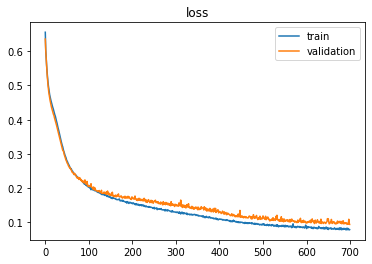

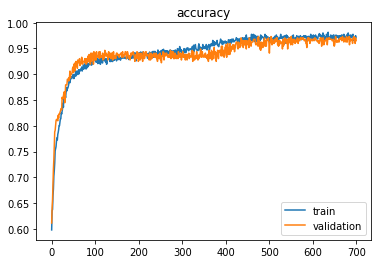

<Figure size 432x288 with 0 Axes>

In [11]:
#plt.yscale('log')
plt.title('loss')
plt.plot(model_output.history['loss'], label='train')
plt.plot(model_output.history['val_loss'], label='validation')
plt.legend()
plt.figure()
#plt.yscale('log')
plt.title('accuracy')
plt.plot(model_output.history['accuracy'], label='train')
plt.plot(model_output.history['val_accuracy'], label='validation')
plt.legend()
plt.figure()

View output

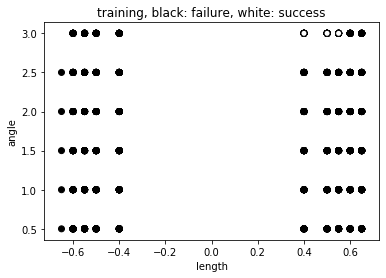

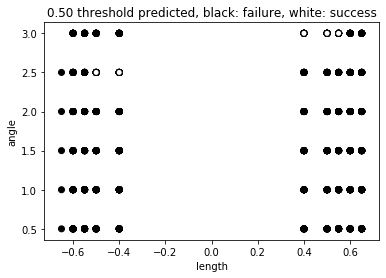

In [13]:
# plot angle vs length with colors from success
threshold = 0.5

plot_x = x
pred_x = x

pred = full_model.predict(pred_x)
pred_success = [0 if i[0] <= threshold else 1 for i in pred] # convert floats to 0/1 output

plt.xlabel("length")
plt.ylabel("angle")
plt.title('training, black: failure, white: success')
plt.scatter([i[0] for i in x], [i[1] for i in x], c=[i[0] for i in y], edgecolors='black', cmap='gray', vmin=0, vmax=1)
plt.figure()

plt.xlabel("length")
plt.ylabel("angle")
plt.title('%0.2f threshold predicted, black: failure, white: success' % threshold)
plt.scatter([i[0] for i in x], [i[1] for i in x], c=pred_success, edgecolors='black', cmap='gray', vmin=0, vmax=1)

Text(0.5, 0, 'velocity')

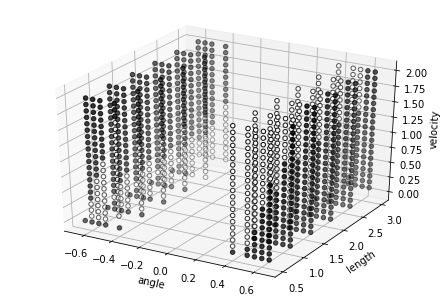

In [14]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter([i[0] for i in x], [i[1] for i in x], [i[2] for i in x], c=pred_success, edgecolors='black', cmap='gray', vmin=0, vmax=1)
ax.set_xlabel('angle')
ax.set_ylabel('length')
ax.set_zlabel('velocity')

Text(0.5, 0, 'velocity')

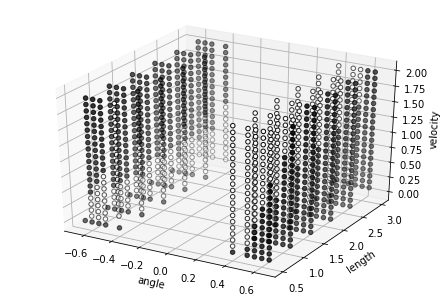

In [15]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter([i[0] for i in x], [i[1] for i in x], [i[2] for i in x], c=[i[0] for i in y], edgecolors='black', cmap='gray', vmin=0, vmax=1)
ax.set_xlabel('angle')
ax.set_ylabel('length')
ax.set_zlabel('velocity')

Save model

In [16]:
full_model.save("ramp_network_2.h5")